# Gymgymnasium/CarRacing with DGN

In this notebook, we train a **vision-based** reinforcement learning agent on the `CarRacing-v2` environment using **Deep Q-Network (DQN)** from Stable-Baselines3.

Goals:

- Use image observations (96×96×3 RGB).
- Train DQN with a **shared training schedule** within the team.
- Log the **reward per episode** and visualize training curves.
- Evaluate **mean reward and variance** at different training stages (checkpoints).
- For each checkpoint, record a **demo video** of the agent driving.

In [16]:
# If you haven't installed the dependencies, run this once:
%pip install swig
%pip install "gymnasium[box2d]"
%pip install stable-baselines3[extra]
%pip install pygame
%pip install imageio[ffmpeg]
%pip install pandas
%pip install matplotlib
%pip install imageio
%pip install stable_baselines3
%pip install tensorboard
%pip install "imageio[ffmpeg]"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: stable-baselines3[extra]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: imageio[ffmpeg]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached imageio_ffmpeg-0.6.0-py3-none-macosx_11_0_arm64.whl.metadata (1.5 kB)
Using cached imageio_ffmpeg-0.6.0-py3-none-macosx_11_0_arm64.whl (21.1 MB)
Note: you may need to restart the kernel to use updated packages.


# Import the Packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

import imageio
import gymnasium as gym
from gymnasium import ActionWrapper

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import torch

# Device Detection (GPU / MPS / CPU)

In [3]:
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon MPS")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA GPU:", torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device("cpu")
    print("Using CPU only")

Using Apple Silicon MPS


# 🏎️ Car Racing v3 Environment
- Documentation https://gymnasium.farama.org/environments/box2d/car_racing/#description

In [4]:
env_id = "CarRacing-v3"
env = gym.make(env_id, render_mode=None)

print("===== OBSERVATION SPACE =====")
print(env.observation_space)
print("Sample observation shape:", env.observation_space.sample().shape)

===== OBSERVATION SPACE =====
Box(0, 255, (96, 96, 3), uint8)
Sample observation shape: (96, 96, 3)


/opt/anaconda3/envs/cs-rl/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


# Model: DQN

In [5]:
carracing_hparams = {
    "total_timesteps": 100_000,
    "checkpoint_steps": [100_000, 300_000, 600_000, 1_000_000],

    # DQN hyperparameters 
    "buffer_size": 100_000,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "gamma": 0.99,

    # env
    "env_id": "CarRacing-v3",

    # live plot
    "plot_every": 1,
    "moving_avg_window": 5,
}

# folders
ALGO_NAME = "DQN"
LOG_DIR   = f"./logs_{ALGO_NAME}"
MODEL_DIR = f"./models_{ALGO_NAME}"
VIDEO_DIR = f"./videos_{ALGO_NAME}"

os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(VIDEO_DIR, exist_ok=True)

In [6]:
class DiscreteCarRacing(ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.actions = [
            np.array([0.0, 0.0, 0.0]),
            np.array([0.0, 1.0, 0.0]),
            np.array([0.0, 0.0, 0.8]),
            np.array([-1.0, 1.0, 0.0]),
            np.array([1.0, 1.0, 0.0]),
            np.array([-1.0, 0.0, 0.0]), # left
            np.array([1.0, 0.0, 0.0]), # right
        ]
        self.action_space = gym.spaces.Discrete(len(self.actions))

    def action(self, act):
        return self.actions[act]
    

# Create training & evaluation environments
def make_train_env():
    def _make():
        env = gym.make(carracing_hparams["env_id"], render_mode=None)
        env = DiscreteCarRacing(env)
        env = Monitor(env, filename=os.path.join(LOG_DIR, "monitor.csv"))
        return env
    return DummyVecEnv([_make])

def make_eval_env(render_mode=None):
    def _make():
        env = gym.make(carracing_hparams["env_id"], render_mode=render_mode)
        env = DiscreteCarRacing(env)
        return env
    return DummyVecEnv([_make])

train_env = make_train_env()

In [7]:
model = DQN(
    "CnnPolicy",
    train_env,
    learning_rate=carracing_hparams["learning_rate"],
    buffer_size=carracing_hparams["buffer_size"],
    batch_size=carracing_hparams["batch_size"],
    gamma=carracing_hparams["gamma"],
    learning_starts=10_000,
    train_freq=4,
    target_update_interval=10_000,
    exploration_fraction=0.3,
    exploration_final_eps=0.05,
    verbose=1,
    tensorboard_log=LOG_DIR,
)

Using cpu device
Wrapping the env in a VecTransposeImage.


/opt/anaconda3/envs/cs-rl/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.53GB > 4.62GB
  warnings.warn(


# Training: save checkpoints at multiple stages

We train the SAC agent for a total of **1M timesteps**, and save checkpoints at:

- 100k steps  
- 300k steps  
- 600k steps  
- 1,000k steps  

During training, we do **not spam print rewards**.  
Instead, we rely on the `Monitor` log and later **plot the episode rewards**.

In [8]:
# Live plot callback: update reward curve during training
class LivePlotCallback(BaseCallback):
    def __init__(self, plot_every=10, moving_avg_window=50, verbose=0):
        super().__init__(verbose)
        self.plot_every = plot_every
        self.moving_avg_window = moving_avg_window
        self.rewards = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos")
        if not infos:
            return True

        for info in infos:
            ep_info = info.get("episode")
            if ep_info is None:
                continue

            r = ep_info["r"]
            self.rewards.append(r)

            if len(self.rewards) % self.plot_every == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 4))
                plt.plot(self.rewards, alpha=0.3, label="Episode reward")

                if len(self.rewards) >= self.moving_avg_window:
                    ma = np.convolve(
                        self.rewards,
                        np.ones(self.moving_avg_window) / self.moving_avg_window,
                        mode="valid"
                    )
                    plt.plot(
                        range(self.moving_avg_window - 1,
                              self.moving_avg_window - 1 + len(ma)),
                        ma,
                        linewidth=2,
                        label=f"{self.moving_avg_window}-ep moving avg"
                    )

                plt.title("Live Training Reward Curve")
                plt.xlabel("Episode")
                plt.ylabel("Reward")
                plt.grid(True)
                plt.legend()
                plt.show()

        return True

In [9]:
def load_or_train(model, start_step, target_step, model_dir, algo_name, callback):
    """
    start_step: ex. 0, 100000, 300000
    target_step: ex. 100000, 300000, 600000
    """
    ckpt_path = os.path.join(model_dir, f"{algo_name}_steps_{target_step}.zip")

    # If checkpoint exists, load model
    if os.path.exists(ckpt_path):
        print(f"Found existing checkpoint at {target_step}. Loading…")
        return DQN.load(ckpt_path, env=model.get_env(), device=DEVICE)

    # If not
    train_steps = target_step - start_step
    print(f"Training from {start_step} → {target_step} (steps = {train_steps})")

    model.learn(
        total_timesteps=train_steps,
        reset_num_timesteps=False,
        callback=callback
    )

    # Save model
    model.save(os.path.join(model_dir, f"{algo_name}_steps_{target_step}"))
    print(f"Saved checkpoint: {ckpt_path}")

    return model

## Evaluation Method

In [10]:
def evaluate_checkpoint(step, n_eval_episodes=5):
    env = make_eval_env().envs[0]
    model_path = os.path.join(MODEL_DIR, f"{ALGO_NAME}_steps_{step}.zip")

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Checkpoint not found: {model_path}")

    eval_model = DQN.load(model_path, device=DEVICE)

    rewards = []
    for ep in range(n_eval_episodes):
        obs,_ = env.reset()
        done = False
        total_r = 0

        while not done:
            action,_ = eval_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_r += reward

        rewards.append(total_r)

    env.close()

    mean_r = float(np.mean(rewards))
    var_r  = float(np.var(rewards))
    std_r  = float(np.std(rewards))

    print(f"Evaluation at {step} steps:")
    print(f"  Mean reward = {mean_r:.2f}")
    print(f"  Std         = {std_r:.2f}")
    print(f"  Var         = {var_r:.2f}")

    return mean_r, std_r, var_r

## Record Demo

In [11]:
def record_demo_video(step, max_steps=1000, fps=30):
    ckpt_base = os.path.join(MODEL_DIR, f"{ALGO_NAME}_steps_{step}")
    ckpt_path = ckpt_base + ".zip"
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")

    env = gym.make(carracing_hparams["env_id"], render_mode="rgb_array")
    env = DiscreteCarRacing(env)
    model = DQN.load(ckpt_base, device=DEVICE)

    frames = []
    obs, _ = env.reset()
    done = False
    t = 0
    total_r = 0.0

    while not done and t < max_steps:
        frame = env.render()
        frames.append(frame)

        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_r += reward
        t += 1

    env.close()

    out_path = os.path.join(VIDEO_DIR, f"{ALGO_NAME}_steps_{step}.mp4")
    imageio.mimsave(out_path, frames, fps=fps)
    print(f"Saved demo video: {out_path}")
    print(f"Demo total reward: {total_r:.2f}")

# Train Agent

## Training 0 → 50,000 steps

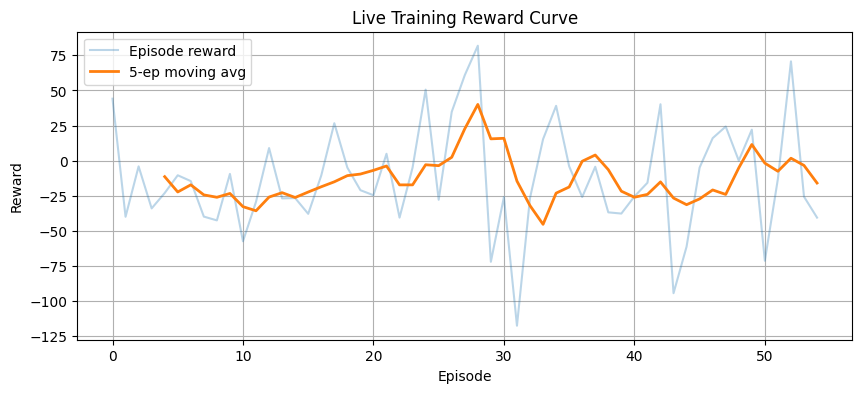

Saved checkpoint at 50k


In [12]:
checkpoint_step = 50_000

live_cb = LivePlotCallback(
    plot_every=carracing_hparams["plot_every"],
    moving_avg_window=carracing_hparams["moving_avg_window"]
)

model.learn(
    total_timesteps=checkpoint_step,
    reset_num_timesteps=True,
    callback=live_cb
)

os.makedirs(MODEL_DIR, exist_ok=True)
model.save(os.path.join(MODEL_DIR, f"{ALGO_NAME}_steps_{checkpoint_step}"))
print(f"Saved checkpoint at {checkpoint_step//1000}k")

In [13]:
# --- evaluate 50k ---
evaluate_checkpoint(50_000)

/opt/anaconda3/envs/cs-rl/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.53GB > 4.11GB
  warnings.warn(


Evaluation at 50000 steps:
  Mean reward = -4.82
  Std         = 32.97
  Var         = 1087.30


(-4.823918038112572, 32.97421867373956, 1087.2990971435945)

In [17]:
# --- record demo video for 50k ---
record_demo_video(50_000, max_steps=1000, fps=30)

/opt/anaconda3/envs/cs-rl/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 5.53GB > 4.01GB
  warnings.warn(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved demo video: ./videos_DQN/DQN_steps_50000.mp4
Demo total reward: 40.74


## Training 50,000 → 100,000 steps

In [ ]:
model = load_or_train(
    model=model,
    start_step=50_000,
    target_step=100_000,
    model_dir=MODEL_DIR,
    algo_name=ALGO_NAME,
    callback=live_cb
)

In [ ]:
# --- evaluate 100k ---
evaluate_checkpoint(200_000)

In [ ]:
# --- record demo video for 100k ---
record_demo_video(200_000, max_steps=1000, fps=30)

## Training 100,000 → 300,000 steps

In [ ]:
model = load_or_train(
    model=model,
    start_step=100_000,
    target_step=300_000,
    model_dir=MODEL_DIR,
    algo_name=ALGO_NAME,
    callback=live_cb
)

In [ ]:
# --- evaluate 300k ---
evaluate_checkpoint(600_000)

In [ ]:
# --- record demo video for 300k ---
record_demo_video(300_000, max_steps=1000, fps=30)

## Training 300,000 → 600,000 steps

In [ ]:
model = load_or_train(
    model=model,
    start_step=300_000,
    target_step=600_000,
    model_dir=MODEL_DIR,
    algo_name=ALGO_NAME,
    callback=live_cb
)

In [ ]:
# --- evaluate 600k ---
evaluate_checkpoint(600_000)

In [ ]:
# --- record demo video for 600k ---
record_demo_video(600_000, max_steps=1000, fps=30)

## Training 600,000 → 1,000,000 steps

In [ ]:
model = load_or_train(
    model=model,
    start_step=600_000,
    target_step=1_000_000,
    model_dir=MODEL_DIR,
    algo_name=ALGO_NAME,
    callback=live_cb
)

In [ ]:
# --- evaluate 1m ---
evaluate_checkpoint(1_000_000)

In [ ]:
# --- record demo video for 1m ---
record_demo_video(100_000, max_steps=1000, fps=30)